Tutorial for this code is available [here](https://adversarial-ml-tutorial.org/introduction/).

[This](https://adversarial-ml-tutorial.org/introduction/introduction.tar.gz) tar.gz file has "pig.jpg" and the trained model's classification classes in a JSON. which you will need to work on. Simply add it to your main directory. 

In [0]:
! ls

imagenet_class_index.json  noise.jpg  pig.jpg  sample_data


(400, 400)
torch.Size([1, 3, 224, 224])


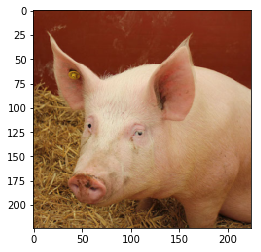

In [0]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

pig_img = Image.open("pig.jpg")
print(pig_img.size)

preprocess = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),])
pig_tensor = preprocess(pig_img)[None,:,:,:]
print(pig_tensor.shape)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [0]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = resnet50(pretrained=True)
model.eval();
pred = model(norm(pig_tensor))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 168889871.72it/s]


In [0]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


"hog" is the superclass of "pig" in taxonomical classification, hence ResNet gives the correct result.

In [0]:
CELoss = nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item()
print(CELoss)

0.0038814544677734375


In [0]:
import numpy as np
print(f"This image has a {np.exp(-CELoss)} probability of being a hog!")

This image has a 0.9961260686399384 probability of being a hog!


Now, we're gonna maximise the probability to fool this network...

In [0]:
import torch.optim as optim
epsilon = 2.0/256

delta = torch.zeros_like(pig_tensor,requires_grad=True)
optimiser = optim.SGD([delta], lr=1e-1)

for t in range(100):
  pred = model(norm(pig_tensor + delta))
  loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
  # -ve because we needa maximise the loss this time
  if t%5 == 0:
    print(f"Loss:   {loss.item()}")
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True Class Probability = ", nn.Softmax(dim=1)(pred)[0,341].item())

Loss:   -0.0038814544677734375
Loss:   -0.00431060791015625
Loss:   -0.00482177734375
Loss:   -0.0054073333740234375
Loss:   -0.0060977935791015625
Loss:   -0.0069332122802734375
Loss:   -0.007966995239257812
Loss:   -0.009241104125976562
Loss:   -0.01084136962890625
Loss:   -0.012966156005859375
Loss:   -0.015836715698242188
Loss:   -0.019762039184570312
Loss:   -0.025501251220703125
Loss:   -0.03465843200683594
Loss:   -0.05031013488769531
Loss:   -0.08090496063232422
Loss:   -0.16553115844726562
Loss:   -0.7009830474853516
Loss:   -3.604891777038574
Loss:   -6.9791693687438965
True Class Probability =  4.118239303352311e-06


In [0]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wombat
Predicted probability: 0.9957990050315857


Yay! We created an image which fools this network into believing that it's a wombat with more than 99% probability. Let's see how our "wombat" looks like. 

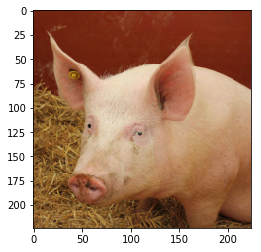

In [0]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Just like a real pig! We just fooled a ResNet. Woo0oOO0oww

But a wombat really isn’t that different from a pig, so maybe the problem isn’t that bad. But it turns out this same technique can be used to make the image classified as virtually any class we desire. This is known as a “targeted attack”, and the only difference is that instead of trying to just maximize the loss of the correct class, we maximize the loss of the correct class while also minimizing the loss of the target class. 

In [0]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(200):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 24.006052017211914
10 -0.1614389419555664
20 -7.630627632141113
30 -15.035181045532227
40 -21.597990036010742
50 -27.058574676513672
60 -30.28807830810547
70 -33.88157653808594
80 -35.42272186279297
90 -37.193817138671875
100 -34.35390090942383
110 -46.24019241333008
120 -46.91464614868164
130 -48.022743225097656
140 -51.40594482421875
150 -50.9544563293457
160 -58.77359390258789
170 -55.75470733642578
180 -60.76509475708008
190 -62.44606399536133


Predicted class:  airliner
Predicted probability: 0.9994298815727234


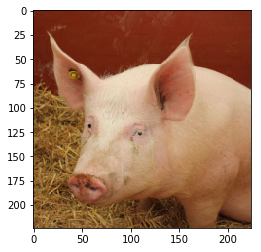

In [0]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

As before, here’s our airliner-pig, looking an awful lot like a normal pig (the target class of 404 from the code is indeed an airliner, so our targeted attack is working)

A brief (incomplete) history of adversarial robustness
* Origins (robust optimization)
* Support vector machines
* Adversarial classification (e.g. Domingos 2004)
* Distinctions between different types of robustness (test test, train time, etc)
* Szgegy et al., 2003, Goodfellow et al., 2004
* Many proposed defense methods
* Many proposed attack methods
* Exact verification methods
* Convex upper bound methods
* Recent trends

The fundamental problem is that when claims are made of “human level” performance by ML systems, they really mean “human level on data generated exactly by the sampling mechanism used in this experiment.” But humans don’t do well just on one sampling distribution; humans are amazingly resilient to changes in the environment. So when people are told that machine learning algorithms “surpass human performance” (especially when conjoined, as they often are, by claims that the associated deep learning algorithms “work like the human brain”), it often leads to the implicit assumption that the algorithms will also be similarly resilient. But they are not; deep learning algorithms are incredibly brittle, and adversarial examples lay this fact bare, in a very obvious and intuitive manner. Put another way, can’t we at least agree to cool it on the “human level”, and “works like the human brain” talk for systems that are as confidence that the first image is a pig as as they are that the second image is an airplane?

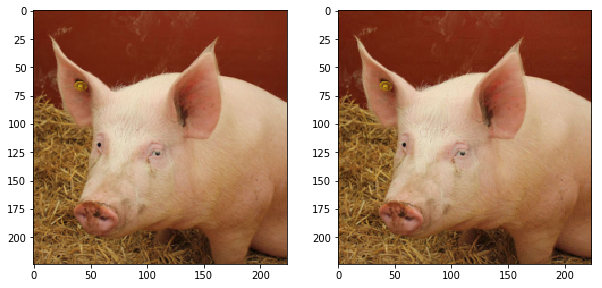

In [0]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Now, we have to think how we can create networks which are robust to these kind of adversarial attacks. This is especially useful in cases like computer security, anti-malwares, anti-spam, and autonomous driving and flying. 

But, as the adversary would say, 

![alt text](http://www.quickmeme.com/img/1b/1b1613968d6036ba31977ad163da08e0d8c805ea26aaa4017b05d63ca6482f62.jpg)
